In [34]:
# Classification
# Source: "Hands-on Machine Learning with Scikit-Learn, Keras & Tensorflow" by Aurélien Géron
# Chapter 3: Classification, code with notes

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In this chapter, in order:
- how to train binary classifiers (5s and not 5s)
- choose the appropriate metric for your task
- evaluate your classifiers using cross-validation
- select the precision/recall tradeoff that fits your needs
- use ROC curves and ROC AUC scores to compare various models
- multiclass classification (detecting more than 5s)

In [118]:
%matplotlib inline

import numpy as np

# Enable printing of multiple outputs per code block
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

# MNIST dataset (70,000 small images of digits handwritten by high school students and employees of the
# U.S. Census Bureau) will be analyzed in this project.

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Datasets loaded by Scikit-Learn have similar dictionary structures:
DESCR key = describing the dataset
data key = containing an array with one row per instance and one column feature
target key = array with labels

In [5]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [7]:
y.shape

(70000,)

There are 70,000 images and each image has 784 features.
Each image is 28 x 28 pixels and each feature simply represents one pixel's intensity, from 0 (white) to 255 (block).

(-0.5, 27.5, 27.5, -0.5)

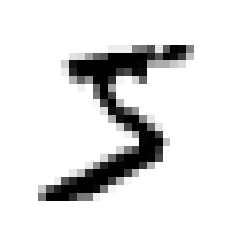

In [32]:
# Look at one digit from the dataset
# Grab an instance's feature vector, reshape it to 28 x 28 array, and display using Matplotlib's imshow() function

import matplotlib as mpl
import matplotlib.pyplot as plt

# iloc returns a series, to_numpy() converts this to NumPy array
some_digit = X.iloc[0].to_numpy()
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")

In [14]:
# Above picture looks like a 5, and we can confirm in the corresponding value in y that this number is supposed to be a 5.
y[0]

'5'

In [35]:
# Label above is a string while ML algorithms expect numbers. Cast y to an integer

y = y.astype(np.uint8)

In [37]:
# Split data into training set and test set
# MNIST is already split into training set (first 60,000 images) and test set (the last 10,000 images)

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Moreover, training set is already shuffled. This is good for 2 reasons:
- Guarantees that all cross-validation folds will be similar (don't want one fold to miss some digits).
- Some learning algorithms will perform poorly if they get many similar instances in a row, since they are sensitive to the order of training instances.

In [38]:
# TRAINING A BINARY CLASSIFIER
# Binary classifer of 5 and not 5 ("5-detector")
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

In [39]:
# Scikit-Learn's Stochastic Gradient Descent (SGD) classifier
# SGDClassifier relies on randomness during training (hence the name "stochastic", random_state parameter used to replicate results)

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [40]:
sgd_clf.predict([some_digit])

array([ True])

The True here means that the classifer guesses that this image represents a 5.

In [45]:
# PERFORMANCE MEASURES

# Evaluating a model - CROSS-VALIDATION (accuracy)
# Following code does the same thing as Scikit-Learn's cross_val_score() function.

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

# StratifiedKFold class performs stratified sampling that produces folds that contain a representative ratio of each class.
# At each iteration, the code creates a clone of the classifier, trains that clone on the training folds, and makes predictions on test folds.
# It counts the number of correct predictions and outputs the ratio of correct predictions.

from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy") # cv=3 means 3 cross-validation folds.

array([0.95035, 0.96035, 0.9604 ])

Above 93% accuracy (ratio of correct predictions) on all cross-validation folds.

In [46]:
# Evaluate the Not-5 Classifier

from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [47]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

The not-5 classifier also has over 90% accuracy on all folds. This is because only 10% of the images are 5s, so if you always guess that image is NOT a 5, you will be right 90% of the time.

= Accuracy is generally NOT the preferred performance measures for classifiers, especially with SKEWED DATASETS.

CONFUSION MATRIX

= A better way to evaluate the performance of classifier is to look at the confusion matrix.
= Idea: count the number of times instance of class A is classified as class B.

In [48]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

How does cross_val_predict differ in comparison to cross_val_score?

- Both perform K-fold cross-validation
- But cross_val_predict returns the predictions made on each test fold instead of returning evaluation scores
- Get clean prediction (prediction made by model that never saw data during training) for each instance in training set

In [49]:
from sklearn.metrics import confusion_matrix

# Confusion matrix - pass target classes (y_train_5) and the predicted classes (y_train_pred)
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [50]:
y_train_perfect_predictions = y_train_5 # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

CONFUSION MATRIX

(Actual, Predicted)
(N, N) = TN (True Negative)
(P, N) = FN (False Negative)
(N, P) = FP (False Positive)
(T, P) = TP (True Positive)

PRECISION: Accuracy of positive predictions
Precision = (TP) / (TP + FP) 

RECALL (SENSITIVITY, TRUE POSITIVE RATE) : ratio of positive instances that are correctly detected by classifier
Recall = (TP) / (TP + FN)

Precision = Ratio of true positives among predictions that are claimed positive by the classifier
Recall = Ratio of true positives detected by the classifier among positives

In [51]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [52]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

Unlike our 90% accuracy conclusion above, now the 5-detector does not look so accurate.
The precision score is 0.837, which means that when the detector claims that the image represents a 5, it is truly a 5 83.7% of the time. Moreover, the recall score is 0.651, which means that only 65.1% of the true 5s are detected.

F1 SCORE: COMBINE PRECISION AND RECALL INTO A SINGLE METRIC
F1 score is the harmonic mean of precision and recall. Harmonic means give more weight to low values, which means that the classifier will only get a high F1 score when both recall and precision scores are high.

F1 = 2 / ((1/precision) + (1/recall))

In [53]:
# F1 score
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

Note: F1 favors classifiers that have similar precision and recall. This might not always be ideal.
For instance, if you trained a classifier to detect videos that are safe for kids, you would prefer classifier that rejects many good videos (low recall) but keeps only safe ones (high precision), rather than a classiier that has a higher recall but lets a few bad videos show up in your product.

PRECISION/RECALL TRADEOFF: Increasing precision reduces recall, and vice versa.

In [57]:
# Instead of calling the classifier predict() method, call decision_function() method (returns a score for each instance)
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [60]:
# SGDClassifier uses threshold equal to 0, so this code returns same result as predict() method
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [61]:
# Raise the threshold
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

Raising the threshold DECREASES recall.

In [65]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

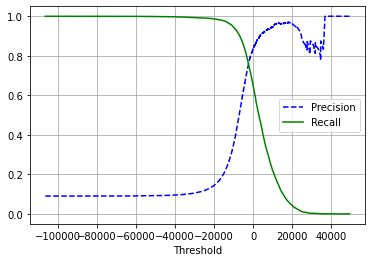

In [72]:
# Use precision-recall curve to compute precision/recall for all possible thresholds
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

# Use Matplotlib to plot precision and recall as functions of threshold value
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.grid(color="darkgrey", linestyle="-", linewidth=0.8)
    plt.legend(loc="best")
    plt.xlabel("Threshold")

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

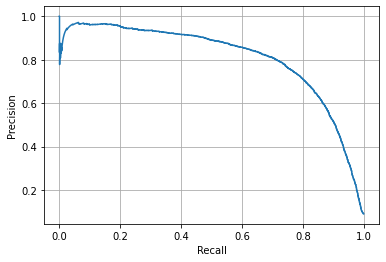

In [73]:
# Visualization: Precision vs. Recall Tradeoff
plt.plot(recalls[:-1], precisions[:-1])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(color="darkgrey", linewidth=0.8)

Precision starts to fall sharply around 80% recall, so may be ideal to select precision/recall tradeoff just before the drop.

In [77]:
# If you aim for 90% precision and search for lowest threshold that gives you at least 90% precision
# np.argmax() will give first index of maximum value, which means the first True value.

threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

y_train_pred_90 = (y_scores >= threshold_90_precision)

In [75]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [76]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

Now there is a 90% precision classifier, but high-precision classifier is not very useful if the recall is too low.

ROC CURVE: RECEIVER OPERATING CHARACTERISTIC (ROC) CURVE
- Another tool commonly used with binary classifiers.
- Similar to precision/recall curve, but instead of plotting precision/recall
- Instead plots TRUE POSITIVE RATE (=recall) against false positive rate (FPR)
- FPR: ratio of negative instances that are incorrectly classified as positive
- equal to 1 - true negative rate (TNR: ratio of negative instances that are correctly classified as negative)
- TNR: also called specificity
- ROC curve plots sensitivity (recall) versus 1 - specificity

Compare classifiers - measure the AREA UNDER THE CURVE (AUC)
- A perfect classifier will have ROC AUC equal to 1 (so ROC curve becoming closer to the top-left corner means that it is a better classifier)
- A purely random classifier will have a ROC AUC equal to 0.5

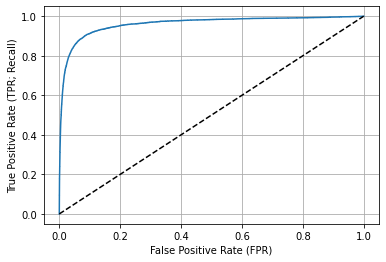

In [96]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal line from 0 to 1
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR; Recall)")
    plt.grid(color="darkgrey", linewidth=0.8)
    
plot_roc_curve(fpr, tpr)
plt.show() # this is optional

ROC Curve plots false positive rate against true positive rate for all possible thresholds.
Red circle highlights chosen ratio (at 43.68% recall).

In [88]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [89]:
# Train Random Forest Classifier to compare its ROC curve and ROC AUC score with SGD Classifier
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [90]:
y_scores_forest = y_probas_forest[:, 1] # score = roba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

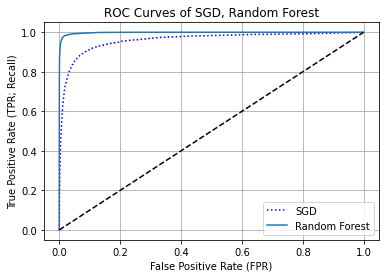

In [98]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.title("ROC Curves of SGD, Random Forest")
plt.show()

The Random Forest Classifier is superior to the SGD classifier because its ROC curve its much closer to the top-left corner, and it has a greater AUC.

In [99]:
# Compare scores directly 
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

Random Forest has ROC AUC score higher than SGD Classifier.

In [105]:
# Random Forest precision score, recall score

MULTICLASS CLASSIFICATION

Multiclass classifiers = multinomial classifiers
- Some algorithms (SGD classifiers, Random Forest classifiers, naive Bayes classifiers) capable of handling multiple classes natively
- Others (Logistic Regression, Support Vector Machine classifiers) are strictly binary classifiers

Can use multiple binary classifiers to perform multiclass classification
Objective: create system that can classify digit images into 10 classes (from 0 to 9)
- One-versus-the-rest(OvR) strategy
    - Train 10 binary classifiers, one for each digit.
    - When you want to classify image, get detector score from each classifier (0 or 1, indicator variable)
    - Select class whose classifier outputs the highest score.
- One-versus-One (OvO) strategy
    - Train binary classifier for every pair of digits
    - Ex. one to distinguish 0s and 1s, another to distinguish 0s and 2s, another to distinguish 1s and 2s.
    - If there are N classes, will need to train N * (N - 1) / 2 classifiers
    - For the MNIST dataset, there are 10 digits 10 * 9 / 2 = 45 classifiers needed
    - Each classifier only needs to be trained on the part of the training set for the two classes that it must distinguish
- OvR or OvO?
    - OvO preferred: Some algorithms (Support Vector Machine classifiers) scale poorly with the size of training set - OvO is faster to train many classifiers on small training sets than to train few classifiers on large training sets
    - For most binary classification algorithms - OvR is preferred

In [106]:
# Scikit-Learn detects when trying to use a binary classification algorithm + automatically runs OvR, OvO
# Try with Support Vector Machine classifier

from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

Code trains SVC on training set using original target classes from 0 to 9 (y_train) instead of the 5-versus-the-rest target classes (y_train_5).
Used OvO strategy under the hood (trained 45 classifiers), got their decision scores for the image, and selected the class (5) that had the highest score.

In [107]:
# Call decision_function() to see individual scores
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [110]:
# Confirm that highest score corresponds to 5
np.argmax(some_digit_scores)
svm_clf.classes_
svm_clf.classes_[5]

5

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

5

When a classifier is trained, it stores the list of target classes in its classes_ attribute, ordered by value.
In this case, classes_ array conveniently matches the class itself (class at index 5 happens to be class 5) but in most cases, this will not be true.

In [111]:
# Make Scikit-Learn use either OvO or OvR - below example uses OvR
# SVC
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])
len(ovr_clf.estimators_)

OneVsRestClassifier(estimator=SVC())

In [113]:
# Training SGD Classifier - did not have to run OvR or OvO because SGD can directly classify instances into multiple classes
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

SGDClassifier(random_state=42)

array([3], dtype=uint8)

In [114]:
# Examine scores that SGD Classifier assigned to each class
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [112]:
# Use cross_val_score() to evaluate SGDClassifier's accuracy
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [115]:
# Scale inputs to increase accuracy
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

In [119]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train , cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

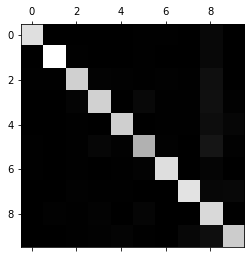

In [117]:
# Image representation of confusion matrix
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

This confusion matrix is pretty good because most images are on the main diagonal, which means taht they were classified correctly. The 5s look slightly darker than other digits, which could mean that there are fewer images of 5s in the dataset or that the classifier does not perform as well on 5s as other digits.

In [ ]:
# Errors
# Divide each value in the confusion matrix by number of images in the corresponding class to compare error rates
row_sums = conf_mx.sum(axis=1, keepdims=True)
# matrix created by dividing row_sums
norm_conf_mx = conf_mx / row_sums

In [ ]:
# Fill diagonal with zeros to keep only the errors, plot result
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

<Figure size 576x576 with 0 Axes>

<AxesSubplot:>

NameError: name 'plot_digits' is not defined

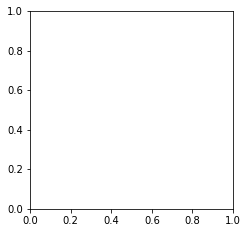

In [120]:
# Analyzing individual errors - more difficult and time consuming
# plot_digits uses Matplotlib's imshow() function
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)

Two 5 x 5 blocks on the left show digits classified as 3s, the two 5 x 5 blocks on the right show images classified as 5s. Most misclassified images seem like obvious errors. This is because we used SGDClassifier (linear model). It assigns weights per class to each pixel and when it sees a new image, sums up weighted pixel intensities to get a score for each class. Since 3s and 5s differ only by a few pixels, model will confuse them.

Because of the shape of 3s and 5s, the classifier is sensitive to image shifting and rotation. So one way to reduce errors is to make sure that 3s and 5s are all well centered and not too rotated.

In [121]:
# MULTILABEL CLASSIFICATION

# Assign multiple classes for each instance (ex. face recognition classifier that sees multiple people)
# Outputs multiple binary tags [1, 0, 1] = Alice yes, Bob no, Charlie yes

from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7) # 7, 8 ,9
y_train_odd = (y_train % 2 == 1) # odd (modulo 1)

# y_multilabel array contains 2 target labels for each image
# first indicates whether or not the digit is large (7, 8, 9) and the second indicates whether or not it is odd
y_multilabel = np.c_[y_train_large, y_train_odd]

# K Neighbors Classifier supports multilabel classification
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [122]:
# Digit 5 is not large (< 7; False) and odd (True)
knn_clf.predict([some_digit])

array([[False,  True]])

In [123]:
# Evaluate a multilabel classifier - average F1 score
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

This assumes that all labels are equally important, but if there are more pictures of Alice to identify with the face recognition classifier, then would be more ideal to place more weight for Alice.
Simple option
- give each label a weight equal to support (the number of instances with that target label).
- average="weighted" in the above code

MULTIOUTPUT CLASSFICATION
- also known as "MULTIOUTPUT-MULTICLASS CLASSIFICATION"
- Example: build a system that removes noise from images
- with Input: noisy digit image, Output: clean digit image, represented as an array of pixel intensities
- This is a multioutput classification system because:
    - Classifier's output is multilabel (one label per pixel)
    - Each label can have multiple values (pixel intensity ranges from 0 to 255).

In [124]:
# Create training and test sets
# Training sets: MNIST images with noise to their pixel intensities from NumPy's randint()
# Test sets: original images

noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_train), 784))
y_train_mod = X_train
y_test_mod = X_test

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)